In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'sans-serif']

In [4]:
aapl = pd.read_csv('aapl-20100101-20190101.csv', header=0, index_col='Date', parse_dates=True)
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,30.478571,30.080000,30.447144,30.104286,88102700.0,26.272409
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704


## 均线交叉策略
移动均线交叉是指资产的价格从移动均线的一侧移动到了另一侧。这一交叉代表了动量的改变，可以作为进入或退出市场的决策点。

对时间序列创建两个独立的简单移动均值（Simple Moving Averages, SMA），它们具有不同的回望周期，比如40天和100天。

如果短期移动均值超过了长期移动均值，那么就做多(买入信号)；如果长期移动均值超过了短期移动均值，那么就退出（卖出信号）。


In [5]:
# 初始化短期和长期窗口
short_window = '40D'
long_window = '100D'

# 初始化 `signals` 数据框，增加 `signal` 列
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 1.0

# 创建短期简单移动均值
signals['short_mavg'] = aapl['Close'].rolling(short_window).mean()

# 创建长期简单移动均值
signals['long_mavg'] = aapl['Close'].rolling(long_window).mean()

# 生成信号
signals['signal'].where(signals['short_mavg'] > signals['long_mavg'], other=0.0, inplace=True)

# 生成交易命令
signals['positions'] = signals['signal'].diff()
signals['positions'].fillna(0, inplace=True)

signals.head()

,signal,short_mavg,long_mavg,positions
Date,,,,
2009-12-31,0.0,30.104286,30.104286,0.0
2010-01-04,0.0,30.338572,30.338572,0.0
2010-01-05,0.0,30.434285,30.434285,0.0
2010-01-06,0.0,30.360357,30.360357,0.0
2010-01-07,0.0,30.304857,30.304857,0.0


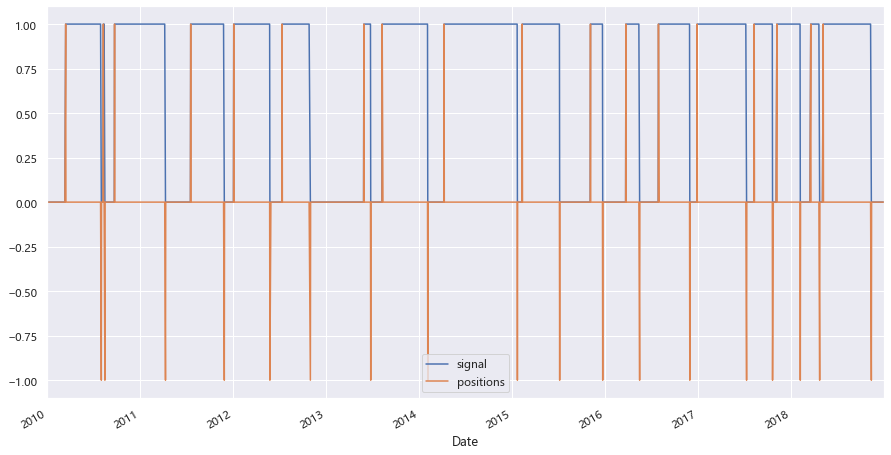

In [6]:
signals[['signal', 'positions']].plot()

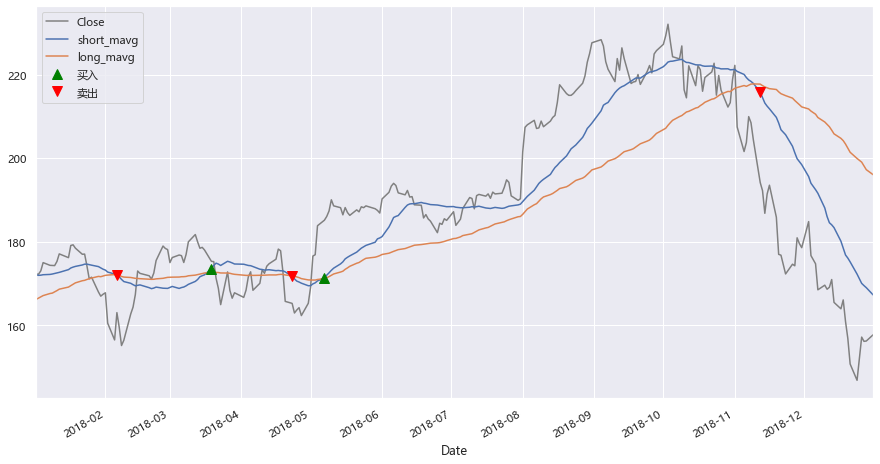

In [7]:
# 绘制收盘价曲线
ax = aapl.loc['2018':'2019', 'Close'].plot(color='gray')

signal_zoom = signals.loc['2018':'2019']

# 绘制短期和长期移动均线
signal_zoom[['short_mavg', 'long_mavg']].plot(ax=ax)

# 绘制买入信号
ax.plot(signal_zoom.loc[signal_zoom.positions == 1.0].index, 
         signal_zoom.short_mavg[signal_zoom.positions == 1.0],
         '^', markersize=10, color='green', label='买入')
         
# 绘制卖出信号
ax.plot(signal_zoom.loc[signal_zoom.positions == -1.0].index, 
         signal_zoom.short_mavg[signal_zoom.positions == -1.0],
         'v', markersize=10, color='red', label='卖出')

ax.legend()
         

## 回溯测试

In [8]:
# 设置初始资金
initial_capital= 10 * 10000.0

# 创建数据框 `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# 当signal为1时，买入100股；-1时，卖出100股
positions['AAPL'] = 100 * signals['signal']   
  
# 用拥有的价值初始化 portfolio
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# 存储股票数目的差值
pos_diff = positions.diff()

# 在 portfolio 中增加 `holdings` 列
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0))  \
                        .sum(axis=1)

# 在 portfolio 中增加`cash`列
portfolio['cash'] = initial_capital  \
                  - (pos_diff.multiply(aapl['Adj Close'], axis=0))  \
                    .sum(axis=1).cumsum()   

# 在 portfolio 中增加`total`列
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# 在 portfolio 中增加`returns` 列
portfolio['returns'] = portfolio['total'].pct_change()
portfolio['returns'].fillna(0, inplace=True)

# 在 portfolie 中增加`yield`列
portfolio['yield'] = (portfolio['total'] / initial_capital) - 1


# 输出`portfolio`的结尾几行
print(portfolio.tail())

            AAPL  holdings           cash          total  returns     yield
Date                                                                       
2018-12-24   0.0       0.0  106787.944221  106787.944221      0.0  0.067879
2018-12-26   0.0       0.0  106787.944221  106787.944221      0.0  0.067879
2018-12-27   0.0       0.0  106787.944221  106787.944221      0.0  0.067879
2018-12-28   0.0       0.0  106787.944221  106787.944221      0.0  0.067879
2018-12-31   0.0       0.0  106787.944221  106787.944221      0.0  0.067879


In [9]:
# portfolio 数据统计
portfolio.describe()

,AAPL,holdings,cash,total,returns,yield
count,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000
mean,6520.115396,6520.115396,97692.284339,104212.399734,0.000030,0.042124
std,6159.287846,6159.287846,5019.402270,2653.225925,0.001216,0.026532
min,0.000000,0.000000,87600.935555,99980.175972,-0.013258,-0.000198
25%,0.000000,0.000000,95069.069862,102144.218254,-0.000220,0.021442
50%,5730.984116,5730.984116,96318.543434,104426.594734,0.000000,0.044266
75%,10693.418884,10693.418884,102144.218254,106683.834267,0.000332,0.066838
max,22852.381897,22852.381897,108120.883369,110453.317451,0.010351,0.104533


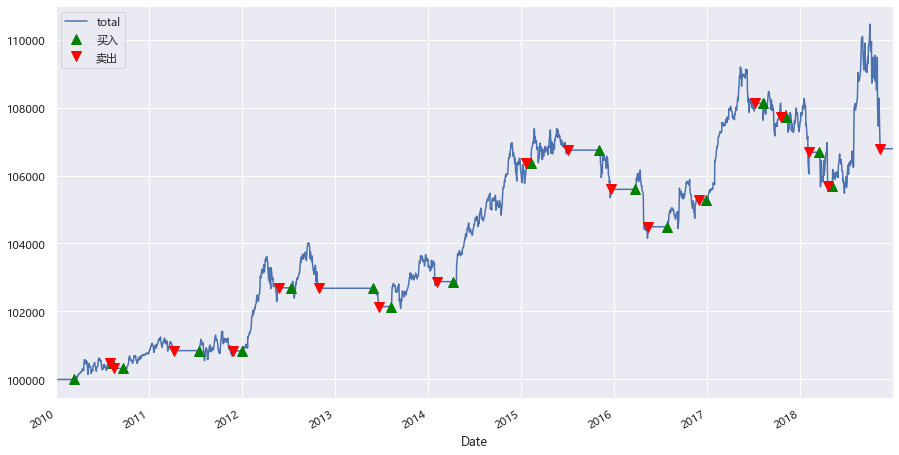

In [10]:
# 绘制资产曲线
ax=portfolio['total'].plot()

ax.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='green', label='买入')
ax.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='red', label='卖出')
ax.legend()

## 继续研究

量化交易开发和测试平台：
https://www.quantopian.com/tutorials/getting-started